In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models


In [23]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout_prob=0.0):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                #nn.Dropout(dropout_prob)  # Apply dropout after ReLU activation
            ]
            return nn.Sequential(*layers)

        self.enc1 = nn.Sequential(
            CBR(in_channels, 64),
            CBR(64, 64)
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            CBR(64, 128),
            CBR(128, 128)
        )
        self.enc3 = nn.Sequential(
            nn.MaxPool2d(2),
            CBR(128, 256),
            CBR(256, 256)
        )
        self.enc4 = nn.Sequential(
            nn.MaxPool2d(2),
            CBR(256, 512),
            CBR(512, 512)
        )
        self.enc5 = nn.Sequential(
            nn.MaxPool2d(2),
            CBR(512, 1024),
            CBR(1024, 1024)
        )

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            CBR(1024, 512),
            CBR(512, 512)
        )

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            CBR(512, 256),
            CBR(256, 256)
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            CBR(256, 128),
            CBR(128, 128)
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            CBR(128, 64),
            CBR(64, 64)
        )

        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return self.conv_last(dec1)

# Example usage:
model = UNet(in_channels=3, out_channels=1)


In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.tif', '.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + '.tif'
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


In [26]:
import torchvision.transforms.functional as TF
from torchvision import transforms

# Parameters
image_dir = '/content/drive/MyDrive/train_images'
mask_dir = '/content/drive/MyDrive/train_masks_discs'
batch_size = 15
num_epochs = 75
learning_rate = 1e-3

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modify the image_transform pipeline to include additional data augmentation
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust the resolution
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Keep the mask_transform pipeline unchanged
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure masks are resized similarly
    transforms.ToTensor()
])

# Update the train_dataset with the new transformations
train_dataset = SegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, transform=image_transform, mask_transform=mask_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = UNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
accumulation_steps = 2  # adjust based on how much memory you can free up

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        loss = loss / accumulation_steps  # normalize the loss
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * images.size(0)

        torch.cuda.empty_cache()

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


torch.save(model.state_dict(), '/content/drive/MyDrive/model.pth')

print("Training finished!")



Epoch 1/75, Loss: 0.2426
Epoch 2/75, Loss: 0.1818
Epoch 3/75, Loss: 0.1440
Epoch 4/75, Loss: 0.1256
Epoch 5/75, Loss: 0.1141
Epoch 6/75, Loss: 0.1056
Epoch 7/75, Loss: 0.0977
Epoch 8/75, Loss: 0.0911
Epoch 9/75, Loss: 0.0860
Epoch 10/75, Loss: 0.0813
Epoch 11/75, Loss: 0.0774
Epoch 12/75, Loss: 0.0739
Epoch 13/75, Loss: 0.0723
Epoch 14/75, Loss: 0.0700
Epoch 15/75, Loss: 0.0672
Epoch 16/75, Loss: 0.0642
Epoch 17/75, Loss: 0.0617
Epoch 18/75, Loss: 0.0591
Epoch 19/75, Loss: 0.0570
Epoch 20/75, Loss: 0.0551
Epoch 21/75, Loss: 0.0533
Epoch 22/75, Loss: 0.0519
Epoch 23/75, Loss: 0.0502
Epoch 24/75, Loss: 0.0493
Epoch 25/75, Loss: 0.0478
Epoch 26/75, Loss: 0.0472
Epoch 27/75, Loss: 0.0459
Epoch 28/75, Loss: 0.0447
Epoch 29/75, Loss: 0.0437
Epoch 30/75, Loss: 0.0426
Epoch 31/75, Loss: 0.0424
Epoch 32/75, Loss: 0.0413
Epoch 33/75, Loss: 0.0407
Epoch 34/75, Loss: 0.0398
Epoch 35/75, Loss: 0.0389
Epoch 36/75, Loss: 0.0382
Epoch 37/75, Loss: 0.0387
Epoch 38/75, Loss: 0.0376
Epoch 39/75, Loss: 0.

In [27]:
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.tif', '.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_name

# Transformations for the test images
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust to the size used during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [28]:
# Load the trained model
model = UNet(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/model.pth'))
model.eval()



UNet(
  (enc1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (enc2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

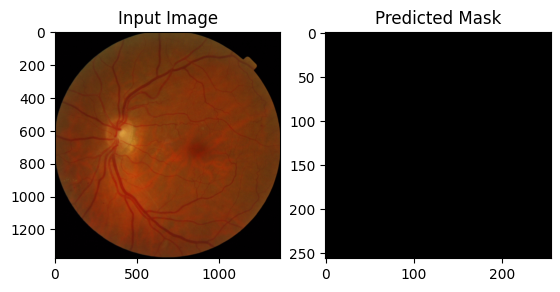

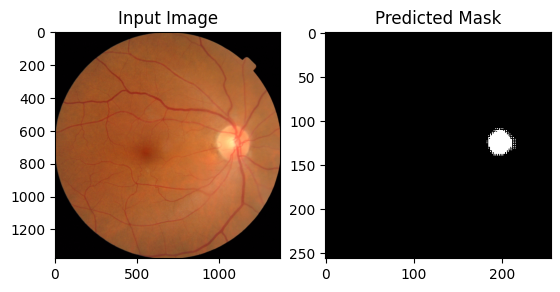

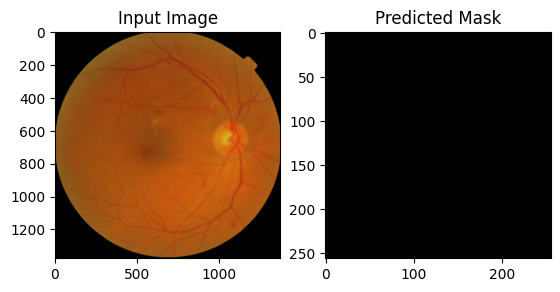

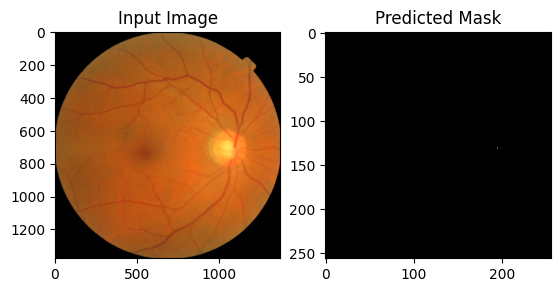

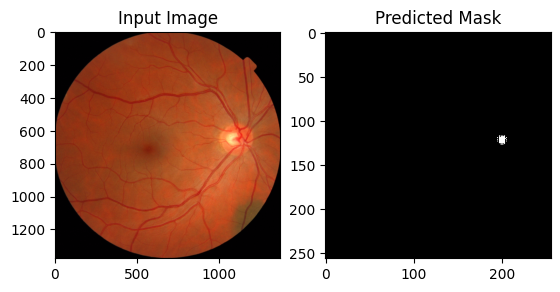

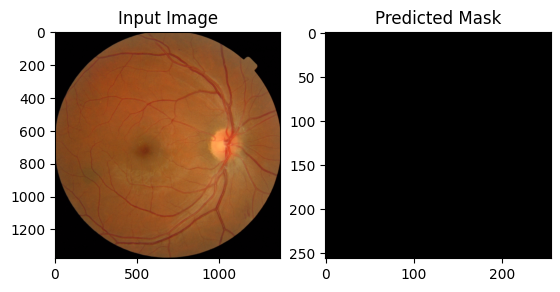

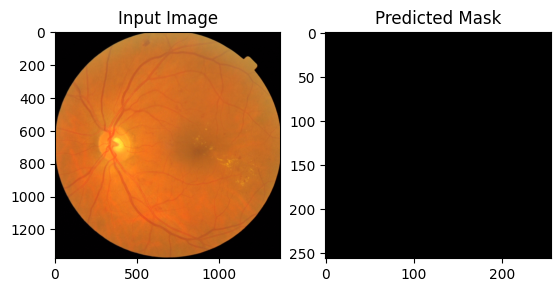

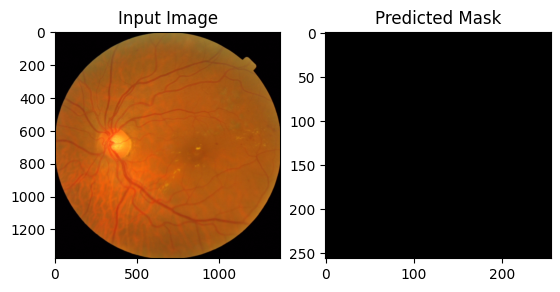

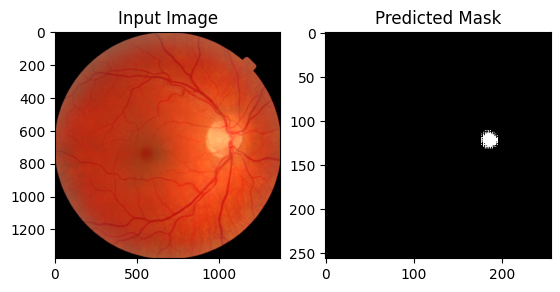

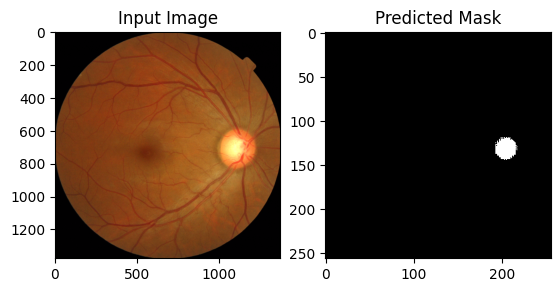

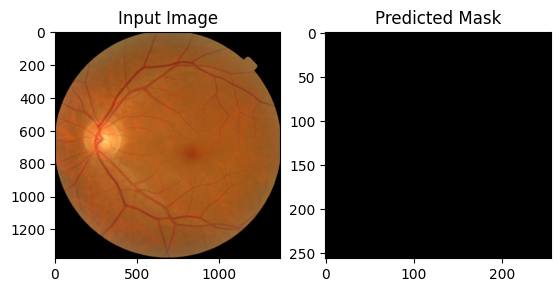

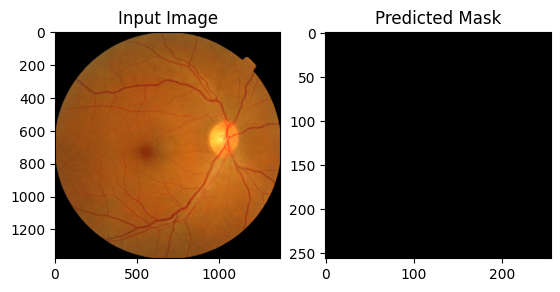

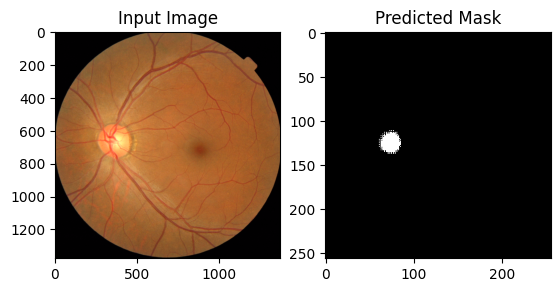

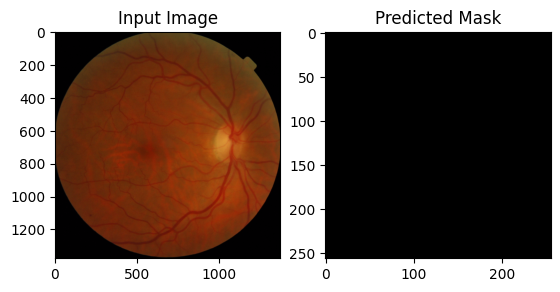

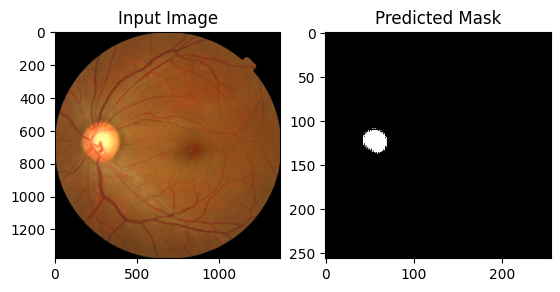

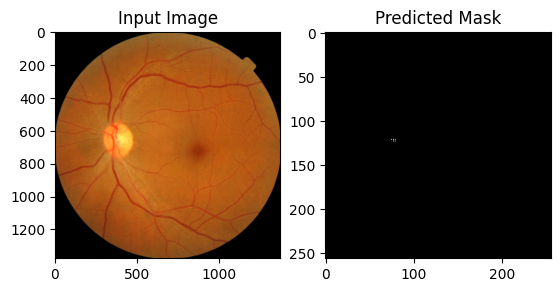

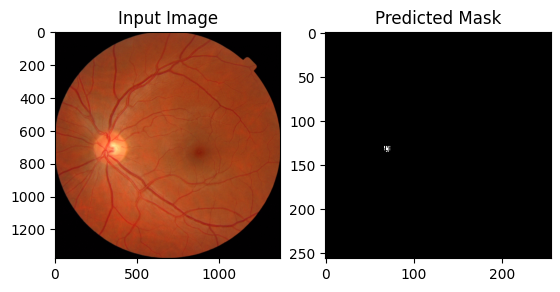

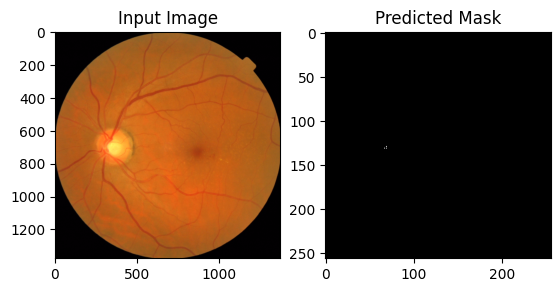

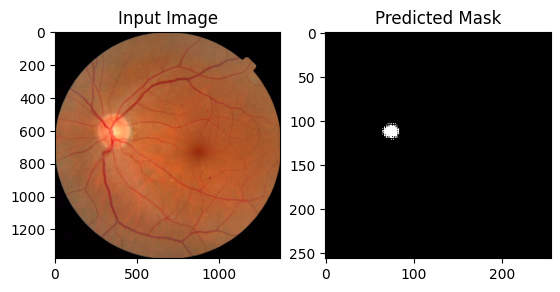

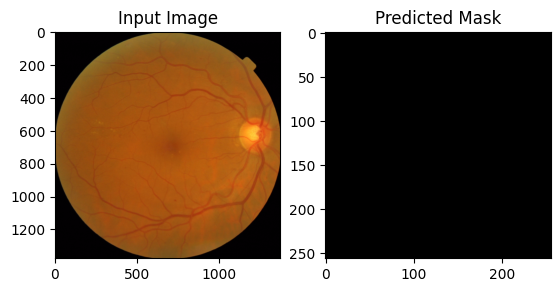

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Parameters
test_image_dir = '/content/drive/MyDrive/test_images'
output_dir = '/content/drive/MyDrive/output_discs'

# Create the test dataset and dataloader
test_dataset = TestDataset(image_dir=test_image_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Run inference
model.eval()
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        preds = (preds > 0.5).float()  # Apply threshold to get binary mask

        for pred, img_name in zip(preds, img_names):
            pred = pred.squeeze().cpu().numpy()  # Convert to numpy array and remove batch dim
            pred = (pred * 255).astype(np.uint8)  # Convert to 8-bit image

            # Save the predicted mask
            pred_image = Image.fromarray(pred)
            pred_image.save(os.path.join(output_dir, img_name.replace('.png', '_pred.png')))

            # Optional: Display the result
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(Image.open(os.path.join(test_image_dir, img_name)))
            plt.title('Input Image')
            plt.subplot(1, 2, 2)
            plt.imshow(pred, cmap='gray')
            plt.title('Predicted Mask')
            plt.show()


In [25]:
test_mask_dir = '/content/drive/MyDrive/test_masks_discs'

val_dataset = SegmentationDataset(image_dir=test_image_dir, mask_dir=test_mask_dir, transform=image_transform, mask_transform=mask_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def accuracy(preds, labels):
    preds = preds > 0.5
    correct = (preds == labels).sum().item()
    return correct / np.prod(labels.shape)

def precision(preds, labels):
    preds = preds > 0.5
    true_positive = ((preds == 1) & (labels == 1)).sum().item()
    predicted_positive = preds.sum().item()
    return true_positive / predicted_positive if predicted_positive != 0 else 0

def recall(preds, labels):
    preds = preds > 0.5
    true_positive = ((preds == 1) & (labels == 1)).sum().item()
    actual_positive = labels.sum().item()
    return true_positive / actual_positive if actual_positive != 0 else 0

def iou(preds, labels):
    preds = preds > 0.5
    intersection = ((preds == 1) & (labels == 1)).sum().item()
    union = ((preds == 1) | (labels == 1)).sum().item()
    return intersection / union if union != 0 else 0

def evaluate(model, loader, device):
    model.eval()
    accs, precs, recs, ious = [], [], [], []
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)

            accs.append(accuracy(preds.cpu(), masks.cpu()))
            precs.append(precision(preds.cpu(), masks.cpu()))
            recs.append(recall(preds.cpu(), masks.cpu()))
            ious.append(iou(preds.cpu(), masks.cpu()))

    print(f"Accuracy: {np.mean(accs):.4f}")
    print(f"Precision: {np.mean(precs):.4f}")
    print(f"Recall: {np.mean(recs):.4f}")
    print(f"IoU: {np.mean(ious):.4f}")

# Evaluate on the validation dataset
evaluate(model, val_loader, device)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same